In [ ]:
pip install -q langchain-core langchain langchain-community tavily-python langchain_anthropic langgraph

### **API키 설정**

In [ ]:
from dotenv import load_dotenv
load_dotenv()

### **사용자가 입력한 키워드에 대한 뉴스 검색 함수**

In [1]:
from tavily import TavilyClient
import os
from langchain_core.tools import tool

# Step 1. Instantiating your TavilyClient
tavily_client = TavilyClient()

def search_recent_news(keyword):
    """
    This tool interacts with the Tavily AI API to search for recent news articles related to a given keyword.

    Args:
        keyword (str): The keyword or phrase to search for in the news articles.

    Returns:
        list: 
        A list of titles, each containing up to 10 of the most recent news articles related to the keyword.
        - 'title' (str): The title of the news article.

    Example:
        response = search_news("OpenAI")
        # Returns a list of news articles published in the last day related to OpenAI.
    """
    article_info = []
    
    # Making the request to the Tavily API
    response = tavily_client.search(
        query=keyword, 
        max_results=10, 
        topic="news", 
        days=7
    )
    title_list = [i['title'] for i in response['results']]
    return title_list


In [2]:
keyword = "OpenAI"
result = search_recent_news(keyword)

In [3]:
result

['Coalition urges California attorney general to halt OpenAI’s for-profit restructuring - Los Angeles Times',
 "OpenAI sues Elon Musk claiming 'bad-faith tactics' - BBC",
 'OpenAI reportedly mulls buying Jony Ive and Sam Altman’s AI hardware startup - TechCrunch',
 "Sam Altman's lawyers roast Elon Musk in scorching new court filing - Business Insider",
 'How A Simple Protocol Is Changing Everything About AI - Forbes',
 'OpenAI gets ready to launch GPT-4.1 - The Verge',
 "OpenAI countersues Elon Musk in legal dispute over ChatGPT maker's business ambitions - Yahoo Finance",
 'Cracks are forming in Elon Musk’s armor of lies - Electrek',
 "Sam Altman's lawyers roast Elon Musk in scorching new court filing - Yahoo",
 'Daniel Lurie’s tech charm offensive in full swing - Politico']

### **뉴스레터 테마 설정 함수**

In [4]:
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

llm = ChatOpenAI(model="gpt-4o-mini", temperature=1)

# Data model
class NewsletterThemeOutput(BaseModel):
    """Output model for structured theme and sub-theme generation."""

    theme: str = Field(
        description="The main newsletter theme based on the provided article titles."
    )
    sub_themes: list[str] = Field(
        description="List of sub-themes or key news items to investigate under the main theme, ensuring they are specific and researchable."
    )


# LLM with function call
structured_llm_newsletter = llm.with_structured_output(NewsletterThemeOutput)

# Prompt
system = """
You are an expert helping to create a newsletter. 
Based on a list of article titles provided, your task is to choose a single, 
specific newsletter theme framed as a clear, detailed question that grabs the reader's attention. 

In addition, generate 5 sub-themes that are highly specific, researchable news items or insights under the main theme. 
Ensure these sub-themes reflect the latest trends in the field and frame them as compelling news topics.

The output should be formatted as:
- Main theme (in question form)
- 3-5 sub-themes (detailed and focused on emerging trends, technologies, or insights).

The sub-themes should create a clear direction for the newsletter, avoiding broad, generic topics.
All your output should be in Korean

"""

# This is the template that will feed into the structured LLM
theme_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Article titles: \n\n {article_titles}"),
    ]
)

# Chain together the system prompt and the structured output model
newsletter_generator = theme_prompt | structured_llm_newsletter

In [5]:
output = newsletter_generator.invoke({"article_titles":result})
subthemes = output.sub_themes
# output

In [6]:
subthemes

['OpenAI의 이익을 위한 구조 변경, 법적 대응은 어떻게 진행되고 있나?',
 '엘론 머스크와 OpenAI의 법적 공방이 AI 생태계에 미치는 잠재적 영향',
 'AI 하드웨어 스타트업 인수를 통한 OpenAI의 전략적 변화',
 'AI 프로토콜의 발전이 산업 전반에 미치는 혁신적 영향',
 'GPT-4.1의 출시와 이를 통한 OpenAI의 시장 점유율 변화 분석']

In [7]:
from typing import List

def subtheme_generator(recent_news: List[str]):
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=1)

    # Data model
    class NewsletterThemeOutput(BaseModel):
        """Output model for structured theme and sub-theme generation."""

        theme: str = Field(
            description="The main newsletter theme based on the provided article titles."
        )
        sub_themes: list[str] = Field(
            description="List of sub-themes or key news items to investigate under the main theme, ensuring they are specific and researchable."
        )
    # LLM with function call
    structured_llm_newsletter = llm.with_structured_output(NewsletterThemeOutput)

    # Prompt
    system = """
    You are an expert helping to create a newsletter. Based on a list of article titles provided, your task is to choose a single, 
    specific newsletter theme framed as a clear, detailed question that grabs the reader's attention. 

    In addition, generate 3 to 5 sub-themes that are highly specific, researchable news items or insights under the main theme. 
    Ensure these sub-themes reflect the latest trends in the field and frame them as compelling news topics.

    The output should be formatted as:
    - Main theme (in question form)
    - 3-5 sub-themes (detailed and focused on emerging trends, technologies, or insights).

    The sub-themes should create a clear direction for the newsletter, avoiding broad, generic topics.
    All your output should be in Korean

    """

    # This is the template that will feed into the structured LLM
    theme_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "Article titles: \n\n {recent_news}"),
        ]
    )

    # Chain together the system prompt and the structured output model
    subtheme_chain= theme_prompt | structured_llm_newsletter
    output = subtheme_chain.invoke({"recent_news":recent_news})
    return output

In [8]:
output = subtheme_generator({"article_titles":result})
subthemes = output.sub_themes
output

NewsletterThemeOutput(theme='AI 기업의 미래: 오픈AI와 엘론 머스크의 법적 전쟁이 산업에 미치는 영향은 무엇인가?', sub_themes=['오픈AI의 이익 구조 변경이 인공지능 산업에 미치는 잠재적 영향', '엘론 머스크와의 법적 싸움에서 드러난 오픈AI의 전략적 방향성', 'Jony Ive와 Sam Altman의 AI 하드웨어 스타트업 인수 가능성 분석', 'AI 산업에서의 새로운 프로토콜 적용이 가져온 혁신적 변화', 'GPT-4.1 출시에 따른 시장 반응과 기술적 진보의 의미'])

### **세부 뉴스를 비동기로 검색하기**

In [9]:
import asyncio
from tavily import AsyncTavilyClient

# tavily_client는 AsyncTavilyClient의 인스턴스
async_tavily_client = AsyncTavilyClient()

async def search_news_for_subtheme(subtheme):
    """
    각 subtheme에 대한 비동기 Tavily API 검색.
    """
    response = await async_tavily_client.search(
        query=subtheme, 
        max_results=5, 
        topic="news", 
        days=7,
        include_images=True,            # 이미지 포함
        include_raw_content=True        # 원본 콘텐츠 포함
    )

    # 각 기사에 맞는 제목, 이미지, 내용 추출
    images = response['images']
    results = response['results']
    
    article_info = []
    for i, result in enumerate(results):
        article_info.append({
            'title': result['title'],
            'image_url': images[i],
            'raw_content': result['raw_content']
        })
    
    return {subtheme: article_info}

async def search_news_by_subthemes(subthemes):
    """
    여러 subtheme에 대한 뉴스를 비동기로 병렬 검색.
    """
    # asyncio.gather를 사용해 여러 비동기 작업 병렬 처리
    results = await asyncio.gather(*[search_news_for_subtheme(subtheme) for subtheme in subthemes])
    
    search_results = {}
    for result in results:
        search_results.update(result)
    
    return search_results

In [10]:
subtheme_search_results = await search_news_by_subthemes(subthemes)
subtheme_search_results

{'오픈AI의 이익 구조 변경이 인공지능 산업에 미치는 잠재적 영향': [{'title': 'Coalition urges California attorney general to halt OpenAI’s for-profit restructuring - Los Angeles Times',
   'image_url': 'https://images.roa.ai/articles/2023/02/bc763312-a5e8-11ed-8a13-0a58a9feac02.png',
   'raw_content': 'Coalition urges California attorney general to halt OpenAI’s for-profit restructuring\nSAN FRANCISCO \xa0—\xa0A coalition of California nonprofits, foundations and labor groups are raising concerns about ChatGPT maker OpenAI, urging the state attorney general to halt the artificial intelligence startup’s plans to restructure itself as a for-profit company.\nMore than 50 organizations, led by LatinoProsperity and the San Francisco Foundation, signed a petition that was sent to Atty. Gen. Rob Bonta’s office on Wednesday, requesting he investigate the Sam Altman-led company.\n“OpenAI began its work with the goal of developing AI to benefit humanity as a whole, but its current attempt to alter its corporate structure

### **본문 작성 함수**

In [12]:

import asyncio
from typing import Dict, List, TypedDict, Annotated
from langchain_core.messages import HumanMessage

from langgraph.graph.message import add_messages



def merge_dicts(left: Dict, right: Dict) -> Dict:
    return {**left, **right}

class State(TypedDict):
    keyword: str
    article_titles: List[str]
    newsletter_theme: NewsletterThemeOutput
    sub_theme_articles: Dict[str, List[Dict]]
    results: Annotated[Dict[str, str], merge_dicts]
    messages: Annotated[List, add_messages]
    
def write_newsletter_section(state: State, sub_theme: str) -> Dict:
    articles = state['sub_theme_articles'][sub_theme]
    
    # Prepare a list of formatted article references including title, image, and a snippet of raw content
    article_references = "\n".join(
        [f"Title: {article['title']}\nContent: {article['raw_content']}..."
         for article in articles]
    )
    
    prompt = f"""
    Write a newsletter section for the sub-theme: "{sub_theme}".
    
    Use the following articles as reference and include relevant points from both their titles, images, and content:
    <article>
    {article_references}
    <article/>
    Summarize the key points and trends related to this sub-theme, and ensure you reference the images where they add value to the discussion. 
    Keep the tone engaging and informative for newsletter readers. You should write in Korean
    """
    
    messages = [HumanMessage(content=prompt)]
    response = llm.invoke(messages)
    return {"results": {sub_theme: response.content}}


def write_newsletter_section(state: State, sub_theme: str) -> Dict:
    return asyncio.run(write_newsletter_section(state, sub_theme))

In [14]:
test_state = {
    'sub_theme_articles': {
        'AI Technology': [
            {
                'title': 'OpenAI Releases GPT-4 Update',
                'raw_content': '''OpenAI has announced a significant update to its GPT-4 model, 
                bringing improvements in reasoning and coding capabilities. The new version shows 
                enhanced performance across various benchmarks and demonstrates better ability 
                to handle complex instructions.'''
            },
            {
                'title': 'AI in Healthcare Makes Breakthrough',
                'raw_content': '''A new AI system has demonstrated remarkable accuracy in early 
                disease detection, potentially revolutionizing preventive healthcare. The system, 
                developed by leading researchers, shows promise in identifying early signs of 
                various conditions.'''
            }
        ]
    },
    'results': {}
}

### **그래프 구축**

In [15]:
import asyncio
from typing import Dict, List, TypedDict, Annotated
from langchain_anthropic import ChatAnthropic
from langgraph.graph import StateGraph, END, START
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph.message import add_messages
import operator
from tavily import TavilyClient
import os



# 동기 함수들
def search_keyword_news(state: State) -> State:
    keyword = state['keyword']
    article_titles = search_recent_news(keyword)
    return {"article_titles": article_titles}

def generate_newsletter_theme(state: State) -> State:
    article_titles = state['article_titles']
    newsletter_theme = newsletter_generator.invoke({"article_titles": "\n".join(article_titles)})
    newsletter_theme.sub_themes = newsletter_theme.sub_themes[:5]
    return {"newsletter_theme": newsletter_theme}

async def search_news_for_subtheme(subtheme):
    async_tavily_client = AsyncTavilyClient()
    response = await async_tavily_client.search(
        query=subtheme, 
        max_results=5, 
        topic="news", 
        days=1,
        include_images=True,
        include_raw_content=True
    )
    images = response['images']
    results = response['results']
    
    article_info = []
    for i, result in enumerate(results):
        article_info.append({
            'title': result['title'],
            'image_url': images[i],
            'raw_content': result['raw_content']
        })
    
    return {subtheme: article_info}

async def search_sub_theme_articles(state: State) -> State:
    subthemes = state['newsletter_theme'].sub_themes
    results = await asyncio.gather(*[search_news_for_subtheme(subtheme) for subtheme in subthemes])
    
    sub_theme_articles = {}
    for result in results:
        sub_theme_articles.update(result)
    
    return {"sub_theme_articles": sub_theme_articles}

async def write_newsletter_section_async(state: State, sub_theme: str) -> Dict:
    articles = state['sub_theme_articles'][sub_theme]
    
    # Prepare a list of formatted article references including title, image, and a snippet of raw content
    article_references = "\n".join(
        [f"Title: {article['title']}\nContent: {article['raw_content']}..."
         for article in articles]
    )
    
    prompt = f"""
    Write a newsletter section for the sub-theme: "{sub_theme}".
    
    Use the following articles as reference and include relevant points from both their titles, images, and content:
    <article>
    {article_references}
    <article/>
    Summarize the key points and trends related to this sub-theme, and ensure you reference the images where they add value to the discussion. 
    Keep the tone engaging and informative for newsletter readers. You should write in Korean
    """
    
    messages = [HumanMessage(content=prompt)]
    response = await llm.ainvoke(messages)
    return {"results": {sub_theme: response.content}}


def write_newsletter_section(state: State, sub_theme: str) -> Dict:
    return asyncio.run(write_newsletter_section_async(state, sub_theme))


def aggregate_results(state: State) -> State:
    theme = state['newsletter_theme'].theme
    combined_newsletter = f"# {theme}\n\n"
    for sub_theme, content in state['results'].items():
        combined_newsletter += f"## {sub_theme}\n{content}\n\n"
    return {"messages": [HumanMessage(content=f"Generated Newsletter:\n\n{combined_newsletter}")]}

def edit_newsletter(state: State) -> State:
    theme = state['newsletter_theme'].theme
    combined_newsletter = state['messages'][-1].content

    prompt = f"""
    As an expert editor, review and refine the following newsletter on the theme: {theme}

    {combined_newsletter}

    Please ensure:
    0. Title should be in question form. subtitles are free to make question or just sentence.
    1. Consistent tone and style throughout the newsletter
    2. Smooth transitions between sections
    3. Proper formatting and structure
    4. Clear and engaging language
    5. No grammatical or spelling errors

    Provide the edited version of the newsletter.
    """

    messages = [HumanMessage(content=prompt)]
    writer_llm = ChatOpenAI(model="gpt-4o-mini", temperature=1, max_tokens = 8192)
    response = writer_llm.invoke(messages)  # 'ainvoke'를 'invoke'로 변경
    
    return {"messages": [HumanMessage(content=f"Edited Newsletter:\n\n{response.content}")]}
    
# LangGraph 구성
workflow = StateGraph(State)
workflow.add_node("editor", edit_newsletter)
# 노드 추가
workflow.add_node("search_news", search_keyword_news)
workflow.add_node("generate_theme", generate_newsletter_theme)
workflow.add_node("search_sub_themes", search_sub_theme_articles)
workflow.add_node("aggregate", aggregate_results)

workflow.add_edge("aggregate", "editor")
workflow.add_edge("editor", END)

for i in range(5):
    node_name = f"write_section_{i}"
    workflow.add_node(node_name, lambda s, i=i: write_newsletter_section(s, s['newsletter_theme'].sub_themes[i]))

# 엣지 연결
workflow.add_edge(START, "search_news")
workflow.add_edge("search_news", "generate_theme")
workflow.add_edge("generate_theme", "search_sub_themes")
for i in range(5):
    workflow.add_edge("search_sub_themes", f"write_section_{i}")
    workflow.add_edge(f"write_section_{i}", "aggregate")

# 그래프 컴파일
graph = workflow.compile()

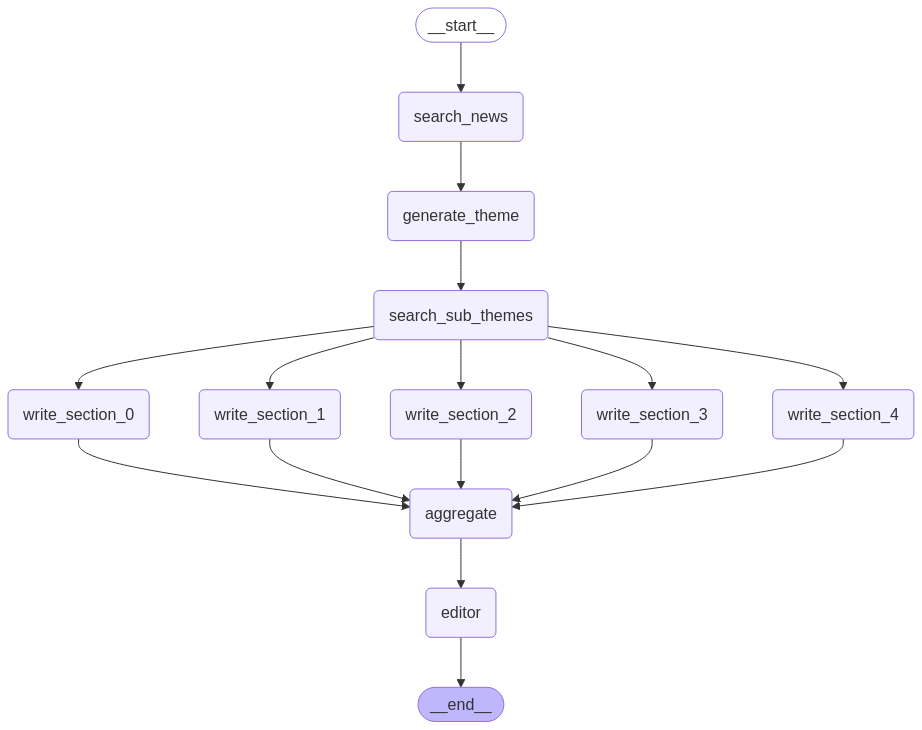

In [16]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [17]:
keyword = input("Enter a keyword for the newsletter: ")

inputs = {"keyword": keyword}
async for output in graph.astream(inputs, stream_mode="updates"):
    # stream_mode="updates" yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(print(value))
    print("\n---\n")

Output from node 'search_news':
---
{'article_titles': ['Microsoft: April 2025 updates break Windows Hello on some PCs - BleepingComputer', 'A Vogue editor’s top picks at this year’s Watches & Wonders - Vogue Australia', 'Government : Hello, Iowa House District 84 from the State Capitol! - Vinton Today', 'Latest LIVE News Trending Today, Real Time Updates: Rahul Gandhi Leaves For Bihar To Join Kanhaiya Kumar’s ‘Palayan Roko Naukri Do’ Yatra - news24online.com', "Software engineers are getting their job offers 'downleveled' more often, says former Meta manager - Business Insider", "Arsenal vs. Real Madrid final score: UEFA Champions League result, stats as Rice magic demolishes Ancelotti's men - sportingnews.com", '"POV You Got To Bring A Random Stranger Back To Their Younger Self For A Minute" - InspireMore', 'Will T.J. Watt, Steelers renew vows — or divorce? - NBC Sports', 'Olivier Awards 2025: Lesley Manville and John Lithgow score top acting prizes - BBC', 'Microsoft Windows 95 rebo

In [18]:
print("""'Edited Newsletter:\n\n# 인공지능의 미래: OpenAI는 어떤 방향으로 나아가고 있는가?\n\n## OpenAI가 최초의 수석 경제학자를 임명한 이유는 무엇인가?\n\nOpenAI는 지난달 경제학 분야의 전문성을 강화하기 위해 최초의 수석 경제학자를 임명했습니다. 이는 AI 기술을 경제 체계와 사회 전반에 더 효과적으로 통합하기 위한 기초 작업으로, OpenAI의 전략적 방향을 명확히 하는 데 중요한 역할을 할 것으로 기대됩니다.\n\nPC Gamer의 보도에 따르면, OpenAI를 포함한 주요 기술 기업들은 온라인 작업을 자동화할 수 있는 AI 시스템을 개발하고 있으며, 이러한 발전은 생산성을 극대화하고 사용자들이 다양한 업무에서 받는 부담을 경감하는 데 기여할 것이라고 합니다. 새로운 수석 경제학자는 이러한 AI 시스템이 경제에 미치는 영향을 분석하고, 기업 및 개인이 AI 도구를 사용하여 얻을 수 있는 최대의 효용을 연구하는 역할을 맡게 될 것입니다.\n\nWharton 대학교의 Ethan Mollick 교수는 기업들이 AI의 잠재적 이익을 실현하기 위해서는 조직 구조의 변화를 이행해야 한다고 강조했습니다. 이는 단순히 기술을 제공하는 데 그치지 않고, 기술의 효과적인 활용법에 대한 깊은 통찰력이 필요하다는 점과 관련이 있습니다. AI의 활용이 전략적으로 이루어지지 않으면 생산성 향상에 기여하지 않을 수 있다는 연구 결과도 나왔습니다.\n\nOpenAI의 경제학 팀은 AI 기술의 전반적인 발전에 기여하는 것을 목표로 하고 있으며, 기업들이 AI를 통해 경쟁력을 강화할 수 있도록 돕는 데 주력할 것입니다. 이러한 노력은 결국 AI와 경제의 조화로운 발전으로 이어질 것으로 기대됩니다. 우리는 이 변화가 기술적 혁신을 넘어 보다 넓은 사회적, 경제적 시스템에 긍정적인 영향을 미칠 수 있기를 희망합니다.\n\n## OpenAI의 ‘Orion’ 모델 발표 지연이 미친 영향은 무엇인가?\n\nOpenAI의 차세대 AI 모델 ‘Orion’의 발표가 지연됨에 따라 여러 가지 기술적 및 전략적 현상이 관찰되고 있습니다. OpenAI는 공식적으로 2024년 12월 출시 계획을 부인하며, 올해 ‘Orion’ 모델이 출시되지 않을 것이라고 밝혔습니다. 이에 대해 CEO 샘 알트만은 ‘가짜 뉴스’라고 반박하며, 모델 출시 일정의 불확실성을 강조했습니다.\n\n‘Orion’ 모델은 기존의 GPT-4보다 최대 100배 더 강력할 것으로 예상되었지만, 발표 지연으로 인한 기술적 경쟁에서의 기회 손실이 우려되고 있습니다. 특히 Microsoft와의 파트너십을 통해 Azure에서 조기 호스팅이 가능하다는 소식이 있었지만, 구체적인 계획은 아직 미비한 상태입니다.\n\n현재 OpenAI는 ‘Orion’ 외에도 ‘Strawberry’라는 다른 모델을 개발 중입니다. 이는 OpenAI가 단일 모델에 집중하기보다는 다양한 접근 방식을 통해 기술을 발전시키고 있음을 의미합니다. 또한 알트만 CEO는 최근 트위터에서 “밤하늘은 정말 아름답고, 겨울 별자리를 기대하고 있다”라는 메시지를 남기며, 향후 모델에 대한 기대감을 조절하는 발언을 했습니다.\n\n결론적으로, ‘Orion’ 모델의 발표 지연은 OpenAI의 기술 개발 로드맵에 중대한 영향을 미치고 있으며, 향후 모델 공개 일정은 여전히 미지수입니다. 이러한 변화는 AI 업계의 경쟁 구조와 기업 전략에 커다란 영향을 미칠 것으로 보입니다.\n\n## OpenAI와 Anthropic 간의 추론 모델 경쟁은 어떻게 진행되고 있을까?\n\nAI 분야의 경쟁이 심화되는 가운데 OpenAI와 Anthropic 간의 새로운 동향이 주목받고 있습니다. 두 기업 모두 사용자 컴퓨터에서 온라인 작업을 수행할 수 있는 AI 시스템, 즉 컴퓨터-사용 에이전트(CUA)를 개발하고 있습니다. 이러한 시스템은 사용자 요구에 맞춰 효율적으로 작업을 수행하는 데 중점을 두고 있으며, 현재 구글의 ‘프로젝트 자비스’와 OpenAI의 ‘스트로베리’ 프로젝트가 대표적입니다.\n\nOpenAI는 ‘스트로베리’ 프로젝트를 통해 인터넷에서 독립적으로 탐색하고 깊이 있는 연구를 수행할 수 있는 AI 모델을 개발 중입니다. 반면, Anthropic은 ‘클로드 3.5 소네트’ 모델을 통해 사용자에게 기존의 컴퓨터 작업을 처리할 수 있는 능력을 제공합니다. 이러한 흐름은 AI 시스템이 사용자의 요구에 맞춰 작업을 자동화하고, 사용자 경험을 향상시키기 위한 기업 간 경쟁을 불러일으키고 있습니다.\n\nOpenAI는 ‘Orion’ 모델이 2024년 12월 출시되지 않을 것이라고 공식 발표했지만, 여전히 업계에서는 ‘Orion’이 100배 이상 강력한 모델이 될 것이라는 기대가 존재합니다. 이는 OpenAI가 지속적으로 기술 혁신을 시도하고 있다는 신호로 해석됩니다.\n\n마지막으로, 네이처의 연구 결과에 따르면 인간과 AI의 조합이 항상 최적의 성과를 내지 않음을 명심해야 합니다. 연구는 인간과 AI의 결합이 특정 작업에서 훌륭한 성과를 낼 수 있지만, 다른 경우에는 오히려 저조할 수 있음을 시사합니다. 따라서 AI와 인간의 협력이 다양한 산업에서 어떻게 작용하는지를 검토할 필요성이 커지고 있습니다.\n\n## OpenAI의 리더십 변화가 기업 전략에 미치는 영향은 무엇인가?\n\nOpenAI 내부에서 발생한 리더십 변화는 기업 전략에 상당한 영향을 미칠 것으로 예상됩니다. 이러한 변화는 새로운 비즈니스 모델 개발, AI 기술의 배포에 대한 접근법, 그리고 조직문화의 변화를 반영하고 있습니다.\n\nWharton 대학교의 Ethan Mollick 교수는 기업이 AI의 혜택을 제대로 누리기 위해서는 조직 차원에서의 변화가 필수적이라고 강조합니다. AI 기술은 개인 단위에서 사용하는 것을 넘어 전략적으로 배치되어야 하며, 변화하지 않으면 큰 이익을 보지 못할 것이라는 경고도 덧붙였습니다.\n\nAI와 인간의 협력의 중요성도 간과할 수 없습니다. Averi AI와 같은 스타트업은 AI를 활용하여 마케팅 업무를 자동화하면서도 여전히 인간의 전문성이 필요하다는 점을 강조합니다. 이러한 접근은 기업이 AI 도구를 적절히 활용하고 신뢰를 구축하는 데 도움을 줄 것입니다.\n\nAI 기술의 부정적 인식에도 불구하고, Adobe의 고위 임원들은 아티스트들이 AI 기술을 수용하지 않으면 성공하기 어려울 것이라는 강력한 메시지를 전달했습니다. 이는 기업들이 AI 기술을 통한 생산성을 강조하고 있으며, AI 도구가 사용자의 성공에 기여할 것이라는 확신을 나타냅니다.\n\nForbes의 연구에 따르면, 기업의 80%는 직원들이 성장 마인드셋을 가져야 수익이 증가한다고 응답했습니다. 직원들이 지속적인 학습과 개발을 통해 개인의 능력을 극대화할 수 있는 환경을 조성하는 것이 앞으로의 기업 전략에서 매우 중요할 것입니다.\n\nOpenAI의 리더십 변화는 단순한 조직 내 변화가 아니라, 기업이 AI를 통해 혁신할 수 있는 기회로 작용할 것입니다. AI의 도입이 조직문화와 전략적 접근 방식을 변화시키고, 결국 기업 전반의 생산성 향상 및 성장으로 이어질 가능성이 높습니다. 그러므로 기업의 리더십 또한 유연하고 혁신적인 사고를 가져야 합니다.\n\n## AGI 준비를 위한 안전팀 해체와 최고 고문 사임, 그 배경은 무엇인가?\n\n최근 인공지능(AGI) 발전을 위한 준비가 중요시되는 가운데, OpenAI의 안전팀 해체와 최고 고문의 사임이라는 중대한 사건이 발생했습니다. 이 과정에서 드러나는 이유와 전략을 살펴보겠습니다.\n\n첫째, 안전성을 강화하려는 노력이 있습니다. 최근 호주의 사이버 보안 회사 OpSys Australia는 첫 번째 정보 보안 최고 책임자로 샤나 데일리를 임명했습니다. 그녀는 사이버 운영 팀을 이끌며, 고객과 시스템 전체에 대한 보안을 강화하는 역할을 맡고 있습니다. 이러한 변화는 AGI와 관련된 데이터 및 시스템의 안전성을 보장하기 위한 선도적인 조치로 해석됩니다.\n\n둘째, 비용 효율성을 추구하는 움직임이 있습니다. 인도 타타 재단은 최근 CFO 및 COO의 직무를 제거하고 외부 컨설턴트의 의존도를 줄이는 재구성을 단행했습니다. 이는 급증하는 인건비와 행정 비용을 절감하고 본래의 자선 사명에 자원을 집중하기 위한 전략적 판단으로 보입니다.\n\n셋째, 조직의 민첩성을 높이기 위한 노력으로 볼 수 있습니다. 태타 재단이 채택한 보다 날렵한 관리 구조는 공동 결정 방식을 통해 운영 효율성을 높이고 AGI의 맥락 변화에 적절히 대응할 수 있도록 설계되었습니다. 이는 과거의 비효율성을 극복하고, 더 나은 의사결정을 통해 AGI 발전의 기회를 최대화할 수 있는 환경을 조성합니다.\n\n이러한 변화들은 AGI와 사이버 보안의 미래를 대비하기 위한 명확한 전략으로 읽을 수 있습니다. 중요한 것은 이러한 조치들이 기존의 대응 방식을 개선하고, 기술적 진보와 관련된 리스크를 얼마나 효과적으로 관리할 수 있을 것인가입니다. 향후 AGI 분야에서의 안전성과 혁신 사이의 균형을 맞추는 것이 주목됩니다. \n\n여러분의 의견은 어떠신가요? AI의 발전에 대한 여러분의 경험과 생각을 공유해 주세요!'""")

'Edited Newsletter:

# 인공지능의 미래: OpenAI는 어떤 방향으로 나아가고 있는가?

## OpenAI가 최초의 수석 경제학자를 임명한 이유는 무엇인가?

OpenAI는 지난달 경제학 분야의 전문성을 강화하기 위해 최초의 수석 경제학자를 임명했습니다. 이는 AI 기술을 경제 체계와 사회 전반에 더 효과적으로 통합하기 위한 기초 작업으로, OpenAI의 전략적 방향을 명확히 하는 데 중요한 역할을 할 것으로 기대됩니다.

PC Gamer의 보도에 따르면, OpenAI를 포함한 주요 기술 기업들은 온라인 작업을 자동화할 수 있는 AI 시스템을 개발하고 있으며, 이러한 발전은 생산성을 극대화하고 사용자들이 다양한 업무에서 받는 부담을 경감하는 데 기여할 것이라고 합니다. 새로운 수석 경제학자는 이러한 AI 시스템이 경제에 미치는 영향을 분석하고, 기업 및 개인이 AI 도구를 사용하여 얻을 수 있는 최대의 효용을 연구하는 역할을 맡게 될 것입니다.

Wharton 대학교의 Ethan Mollick 교수는 기업들이 AI의 잠재적 이익을 실현하기 위해서는 조직 구조의 변화를 이행해야 한다고 강조했습니다. 이는 단순히 기술을 제공하는 데 그치지 않고, 기술의 효과적인 활용법에 대한 깊은 통찰력이 필요하다는 점과 관련이 있습니다. AI의 활용이 전략적으로 이루어지지 않으면 생산성 향상에 기여하지 않을 수 있다는 연구 결과도 나왔습니다.

OpenAI의 경제학 팀은 AI 기술의 전반적인 발전에 기여하는 것을 목표로 하고 있으며, 기업들이 AI를 통해 경쟁력을 강화할 수 있도록 돕는 데 주력할 것입니다. 이러한 노력은 결국 AI와 경제의 조화로운 발전으로 이어질 것으로 기대됩니다. 우리는 이 변화가 기술적 혁신을 넘어 보다 넓은 사회적, 경제적 시스템에 긍정적인 영향을 미칠 수 있기를 희망합니다.

## OpenAI의 ‘Orion’ 모델 발표 지연이 미친 영향은 무엇인가?

OpenAI의 차세대 AI 모델 ‘Orion’의 발표가 지연됨에 따라 여러 가지 기